In [19]:
import requests
import time
import csv
from collections import deque
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

# ==========================
# Настройки
# ==========================
ACCESS_TOKEN = ""
API_VERSION = "5.199"
GROUP_MEMBERS = [332942361, 204201117]  # ID участников группы
SLEEP_TIME = 0.4

In [20]:
# VK API
# ==========================
def get_friends(user_id):
    url = "https://api.vk.com/method/friends.get"
    params = {"user_id": user_id, "access_token": ACCESS_TOKEN, "v": API_VERSION}
    response = requests.get(url, params=params).json()
    if "response" in response:
        return response["response"]["items"]
    else:
        print(f"Ошибка для {user_id}: {response}")
        return []


def get_user_name(user_id):
    url = "https://api.vk.com/method/users.get"
    params = {"user_ids": user_id, "access_token": ACCESS_TOKEN, "v": API_VERSION}
    response = requests.get(url, params=params).json()
    try:
        d = response["response"][0]
        return f"{d['first_name']} {d['last_name']}"
    except:
        return str(user_id)


def build_network(user_ids):
    network = {}
    for uid in user_ids:
        friends = get_friends(uid)
        network[uid] = friends
        print(f"Получены друзья для {uid}: {len(friends)}")
        time.sleep(SLEEP_TIME)
    return network


def build_friends_of_friends(network):
    network2 = {}
    all_friends = set()
    for f in network.values():
        all_friends.update(f)

    for fid in all_friends:
        friends = get_friends(fid)
        network2[fid] = friends
        print(f"Получены друзья для {fid}: {len(friends)}")
        time.sleep(SLEEP_TIME)
    return network2


def save_network_to_csv(network, filename):
    with open(filename, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["source", "target"])
        for user, friends in network.items():
            for friend in friends:
                writer.writerow([user, friend])
                writer.writerow([friend, user])  # двусторонняя связь


def load_network_from_csv(filename):
    graph = {}
    with open(filename, newline="", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            s, t = int(row["source"]), int(row["target"])
            graph.setdefault(s, set()).add(t)
            graph.setdefault(t, set()).add(s)
    return graph

In [21]:
# Сбор данных VK
# ==========================================
print("🔹 Сбор данных участников...")
friends_network = build_network(GROUP_MEMBERS)
save_network_to_csv(friends_network, "friends.csv")
print("💾 Сохранено friends.csv")

print("🔹 Сбор данных друзей друзей...")
friends2_network = build_friends_of_friends(friends_network)
save_network_to_csv(friends2_network, "friends_of_friends.csv")
print("💾 Сохранено friends_of_friends.csv")

🔹 Сбор данных участников...
Получены друзья для 332942361: 221
Получены друзья для 204201117: 163
💾 Сохранено friends.csv
🔹 Сбор данных друзей друзей...
Ошибка для 320036866: {'error': {'error_code': 30, 'error_msg': 'This profile is private', 'request_params': [{'key': 'user_id', 'value': '320036866'}, {'key': 'v', 'value': '5.199'}, {'key': 'method', 'value': 'friends.get'}, {'key': 'oauth', 'value': '1'}]}}
Получены друзья для 320036866: 0
Получены друзья для 255864835: 498
Получены друзья для 151664647: 75
Ошибка для 440928263: {'error': {'error_code': 30, 'error_msg': 'This profile is private', 'request_params': [{'key': 'user_id', 'value': '440928263'}, {'key': 'v', 'value': '5.199'}, {'key': 'method', 'value': 'friends.get'}, {'key': 'oauth', 'value': '1'}]}}
Получены друзья для 440928263: 0
Получены друзья для 649623563: 108
Получены друзья для 267649039: 712
Ошибка для 246896658: {'error': {'error_code': 30, 'error_msg': 'This profile is private', 'request_params': [{'key': 'u

In [22]:
# Загрузка
# ==========================================
small_graph = load_network_from_csv("friends.csv")
big_graph = load_network_from_csv("friends_of_friends.csv")

print(f"Малый граф узлов: {len(small_graph)}")
print(f"Большой граф узлов: {len(big_graph)}")


def bfs_shortest_paths(graph, start):
    visited = {start: 0}
    queue = deque([start])
    while queue:
        node = queue.popleft()
        for neigh in graph.get(node, []):
            if neigh not in visited:
                visited[neigh] = visited[node] + 1
                queue.append(neigh)
    return visited


def closeness_centrality(graph):
    C = {}
    for node in graph:
        d = bfs_shortest_paths(graph, node)
        rc = len(d) - 1
        C[node] = rc / sum(d.values()) if rc > 0 else 0
    return C


def betweenness_centrality(graph):
    C = {v: 0 for v in graph}
    nodes = list(graph.keys())
    for s, t in itertools.combinations(nodes, 2):
        paths = [[s]]
        shortest = []
        while paths:
            new_paths = []
            for path in paths:
                v = path[-1]
                for neigh in graph[v]:
                    if neigh in path:
                        continue
                    new_path = path + [neigh]
                    if neigh == t:
                        shortest.append(new_path)
                    else:
                        new_paths.append(new_path)
            if shortest: break
            paths = new_paths
        for path in shortest:
            for mid in path[1:-1]:
                C[mid] += 1 / len(shortest)
    return C


def eigenvector_centrality(graph, iterations=100, tol=1e-6):
    nodes = list(graph.keys())
    n = len(nodes)
    idx = {node: i for i, node in enumerate(nodes)}
    A = np.zeros((n, n))
    for i, node in enumerate(nodes):
        for neigh in graph[node]:
            if neigh in idx:
                A[i, idx[neigh]] = 1
    x = np.ones(n)
    for _ in range(iterations):
        x_new = A.dot(x) / np.linalg.norm(A.dot(x))
        if np.linalg.norm(x - x_new) < tol:
            break
        x = x_new
    return {nodes[i]: x[i] for i in range(n)}


print("🔸 Считаем метрики...")
closeness = closeness_centrality(big_graph)
betweenness = betweenness_centrality(small_graph)
eigenvector = eigenvector_centrality(small_graph)

df = pd.DataFrame({
    "id": GROUP_MEMBERS,
    "name": [get_user_name(n) for n in GROUP_MEMBERS],
    "closeness": [closeness.get(n, 0) for n in GROUP_MEMBERS],
    "betweenness": [betweenness.get(n, 0) for n in GROUP_MEMBERS],
    "eigenvector": [eigenvector.get(n, 0) for n in GROUP_MEMBERS],
})

print(df)
df.to_csv("centrality_results.csv", index=False)

Малый граф узлов: 386
Большой граф узлов: 61476
🔸 Считаем метрики...
          id                name  closeness  betweenness   eigenvector
0  332942361         Egor Volkov   0.304893      24310.0  6.711561e-02
1  204201117  Elizaveta Bogaenko   0.356069      13203.0  1.646607e-08


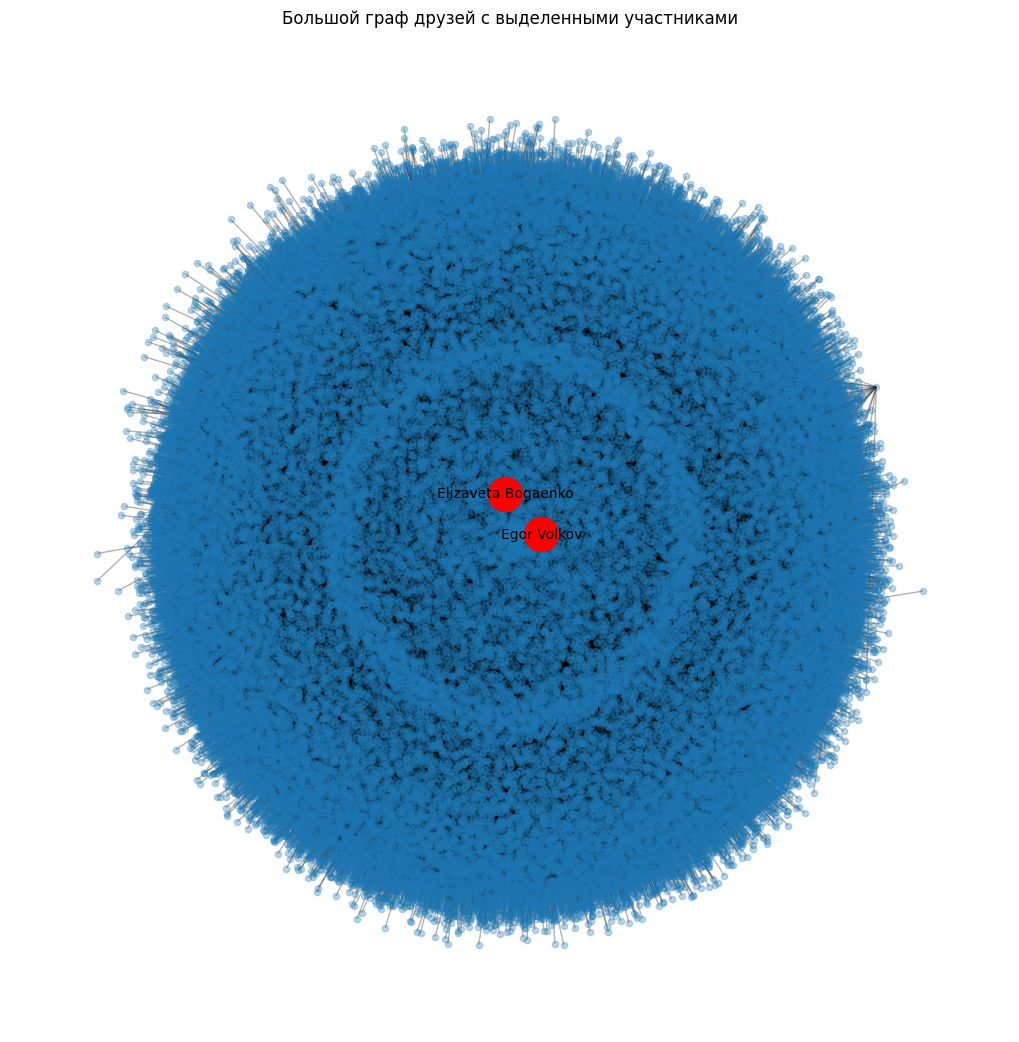

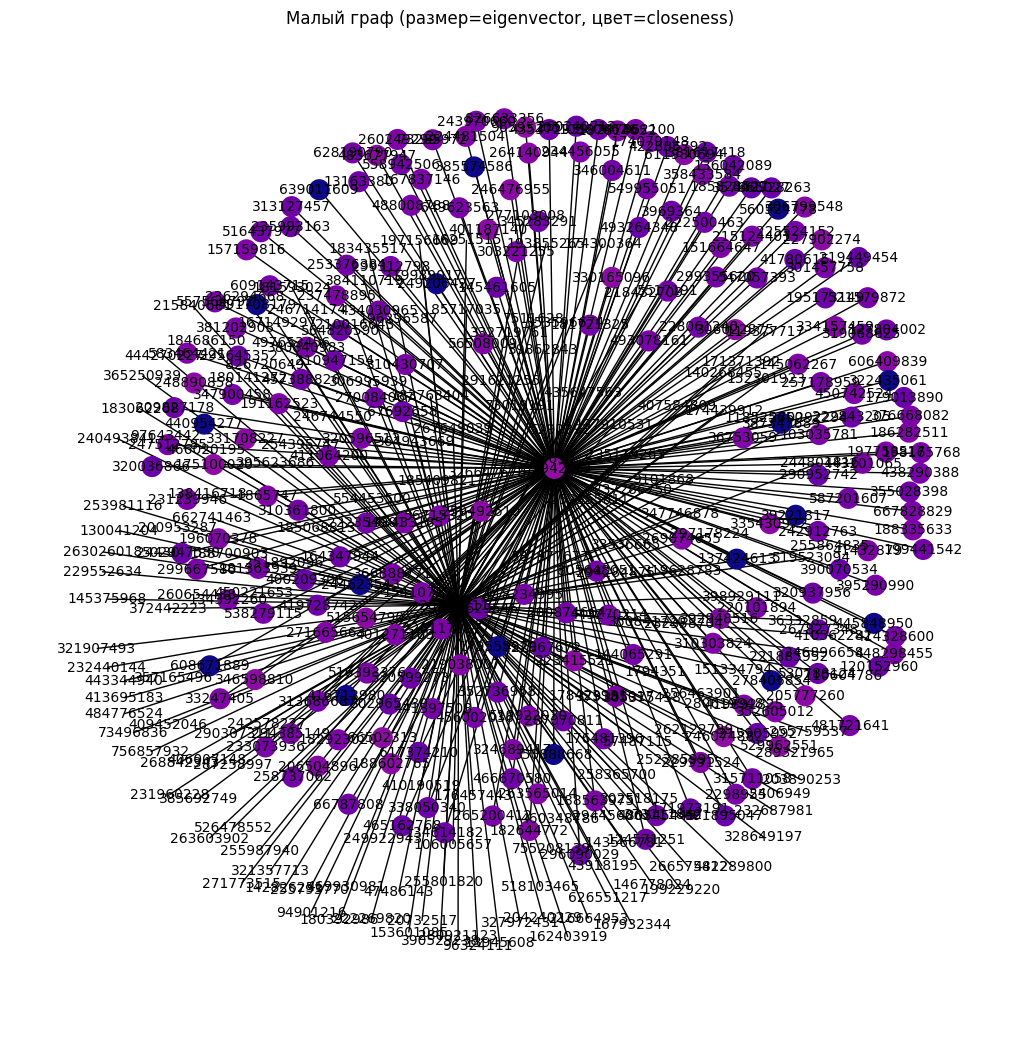

In [23]:
# ========= Визуализация =============
def draw_big_graph(graph):
    G = nx.Graph()
    for n, neighs in graph.items():
        for t in neighs:
            G.add_edge(n, t)
    pos = nx.spring_layout(G, k=0.1)
    plt.figure(figsize=(10, 10))
    nx.draw(G, pos, node_size=20, alpha=0.3)
    nx.draw_networkx_nodes(G, pos, nodelist=GROUP_MEMBERS, node_color="red", node_size=600)
    nx.draw_networkx_labels(G, pos, {n: get_user_name(n) for n in GROUP_MEMBERS}, font_size=10)
    plt.title("Большой граф друзей с выделенными участниками")
    plt.show()


def draw_small_graph(graph):
    G = nx.Graph()
    for n, neighs in graph.items():
        for t in neighs:
            G.add_edge(n, t)
    pos = nx.spring_layout(G, k=0.4)
    sizes = [eigenvector.get(n, 0) * 3000 for n in G.nodes()]
    colors = [closeness.get(n, 0) for n in G.nodes()]
    plt.figure(figsize=(10, 10))
    nx.draw(G, pos, node_size=sizes, node_color=colors, cmap="plasma",
            with_labels=True, font_size=10)
    plt.title("Малый граф (размер=eigenvector, цвет=closeness)")
    plt.show()


draw_big_graph(big_graph)
draw_small_graph(small_graph)


In [15]:
import csv
import networkx as nx
import requests
import time

ACCESS_TOKEN = ""
API_VERSION = "5.199"
GROUP_MEMBERS = [332942361, 204201117]  # ID участников группы
SLEEP_TIME = 0.05

# Все узлы
all_nodes = set(big_graph.nodes()) | set(small_graph.nodes())
users_names = {}

def get_user_name(user_id):
    url = "https://api.vk.com/method/users.get"
    params = {"user_ids": user_id, "access_token": ACCESS_TOKEN, "v": API_VERSION}
    response = requests.get(url, params=params).json()
    try:
        d = response["response"][0]
        return f"{d['first_name']} {d['last_name']}"
    except:
        return str(user_id)

# Получаем имена
for uid in all_nodes:
    users_names[uid] = get_user_name(uid)
    time.sleep(0.34)
    print("имя получено для:", uid)

def name_of(uid):
    return users_names.get(uid, str(uid))

G_big = big_graph
G_small = small_graph

# ---- Добавляем атрибуты ----
for G in [G_big, G_small]:
    for node in G.nodes():
        G.nodes[node]["label"] = name_of(node)
        G.nodes[node]["closeness"] = closeness.get(node, 0)
        G.nodes[node]["betweenness"] = betweenness.get(node, 0)
        G.nodes[node]["eigenvector"] = eigenvector.get(node, 0)
        G.nodes[node]["group_member"] = node in GROUP_MEMBERS

# ---- Сохранение в GEXF ----
nx.write_gexf(G_big, "big_graph_gephi.gexf")
nx.write_gexf(G_small, "small_graph_gephi.gexf")
print("🎉 Экспорт GEXF завершён: big_graph_gephi.gexf, small_graph_gephi.gexf")

# ---- Сохранение всех данных в CSV ----
with open("nodes_data.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["user_id", "name", "closeness", "betweenness", "eigenvector", "group_member"])
    for node in all_nodes:
        writer.writerow([
            node,
            name_of(node),
            closeness.get(node, 0),
            betweenness.get(node, 0),
            eigenvector.get(node, 0),
            node in GROUP_MEMBERS
        ])

print("🎉 Экспорт CSV завершён: nodes_data.csv")


имя получено для: 28966914
имя получено для: 108134402
имя получено для: 421265412
имя получено для: 464257026
имя получено для: 278921228
имя получено для: 104464397
имя получено для: 100401166
имя получено для: 267649039
имя получено для: 249692176
имя получено для: 411959316
имя получено для: 157941786
имя получено для: 111149085
имя получено для: 769785891
имя получено для: 419168294
имя получено для: 59768872
имя получено для: 136314921
имя получено для: 141164584
имя получено для: 8126506
имя получено для: 595460136
имя получено для: 212467754
имя получено для: 134217774
имя получено для: 320864302
имя получено для: 114425910
имя получено для: 445513783
имя получено для: 58589240
имя получено для: 269746233
имя получено для: 33816637
имя получено для: 8126529
имя получено для: 6422595
имя получено для: 290586694
имя получено для: 143392840
имя получено для: 282460232
имя получено для: 394133577
имя получено для: 191234123
имя получено для: 69992525
имя получено для: 417595473
имя

NameError: name 'closeness' is not defined